In [1]:
# !kaggle competitions download -c bike-sharing-demand
# !unzip bike-sharing-demand.zip -d data

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, root_mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV

In [3]:
df = pd.read_csv('data/train.csv',index_col='datetime')

In [4]:
df[['month','hour','weekday','is_weekend']] = pd.DataFrame({
    'month': pd.to_datetime(df.index).month,
    'hour': pd.to_datetime(df.index).hour,
    'weekday': pd.to_datetime(df.index).weekday,
    'is_weekend': [True if x in [5,6] else False for x in pd.to_datetime(df.index).weekday]},
    index=df.index)

df.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,month,hour,weekday,is_weekend
datetime,,,,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,1,0,5,True
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1,1,5,True
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,1,2,5,True
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,1,3,5,True
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,1,4,5,True


In [5]:
# dropping season bc will focus on first quarter
df = df.drop('season', axis=1)

In [6]:
# df = pd.get_dummies(df, columns=['holiday','workingday','weather','month','hour','weekday'], drop_first=True)
df = pd.get_dummies(df, columns=['holiday','workingday','weather'], drop_first=True)

In [7]:
df.head()

,temp,atemp,humidity,windspeed,casual,registered,count,month,hour,weekday,is_weekend,holiday_1,workingday_1,weather_2,weather_3,weather_4
datetime,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,9.84,14.395,81,0.0,3,13,16,1,0,5,True,False,False,False,False,False
2011-01-01 01:00:00,9.02,13.635,80,0.0,8,32,40,1,1,5,True,False,False,False,False,False
2011-01-01 02:00:00,9.02,13.635,80,0.0,5,27,32,1,2,5,True,False,False,False,False,False
2011-01-01 03:00:00,9.84,14.395,75,0.0,3,10,13,1,3,5,True,False,False,False,False,False
2011-01-01 04:00:00,9.84,14.395,75,0.0,0,1,1,1,4,5,True,False,False,False,False,False


In [8]:
df_ref = df.loc['2011-01-01 00:00:00':'2011-01-28 23:00:00']

In [9]:
xgb = GradientBoostingRegressor(random_state = 0)

param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'criterion': ['squared_error'],
    'max_depth': [2, 5, 7, 9, 10, 11, 12],
    }

grid_search = GridSearchCV(xgb, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')

In [10]:
def fit_predict(df: pd.DataFrame):
    X = df.drop(['casual','registered','count'], axis=1)
    y = df['count']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0, shuffle=False)

    grid_search.fit(X_train, y_train)

    y_pred = grid_search.predict(X_test)

    return y_test, y_pred

In [11]:
def metrics(y_test, y_pred):
    me = np.mean(y_pred - y_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = root_mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f'mean error: {me}')
    print(f'mean squared error: {mse}')
    print(f'root mean squared error: {rmse}')
    print(f'r2 score: {r2}')

    plt.figure(figsize=(14,10))
    ax1 = plt.subplot(2,2,(1,2))
    ax1.set_title('Predicted and Actual')
    ax1.plot((y_pred))
    ax1.plot(np.array((y_test)))
    ax1.legend(["Predicted","Actual"])
    ax1.set_xlabel('Test Data and Predicted Data')
    tick_positions = np.linspace(0, len(y_test)-1, num=5, dtype=int)
    ax1.set_xticks(ticks=tick_positions, labels=pd.to_datetime(y_test.index)[tick_positions].strftime('%Y-%m-%d'))

    ax2 = plt.subplot(2,2,3)
    ax2.set_title('Predicted vs Actual')
    ax2.scatter(y_test, y_pred)
    ax2.set_xlabel('Actual value')
    ax2.set_ylabel('Predicted value')

    ax3 = plt.subplot(2,2,4)
    ax3.set_title('Error Distribution')
    ax3.hist(y_pred - y_test, bins=20)
    ax3.set_ylabel('Predicted - Actual')

# Reference

In [12]:
y_test, y_pred = fit_predict(df_ref)

mean error: -1.6655289481433837
mean squared error: 415.3984830724301
root mean squared error: 20.381326823159235
r2 score: 0.7904177155995564


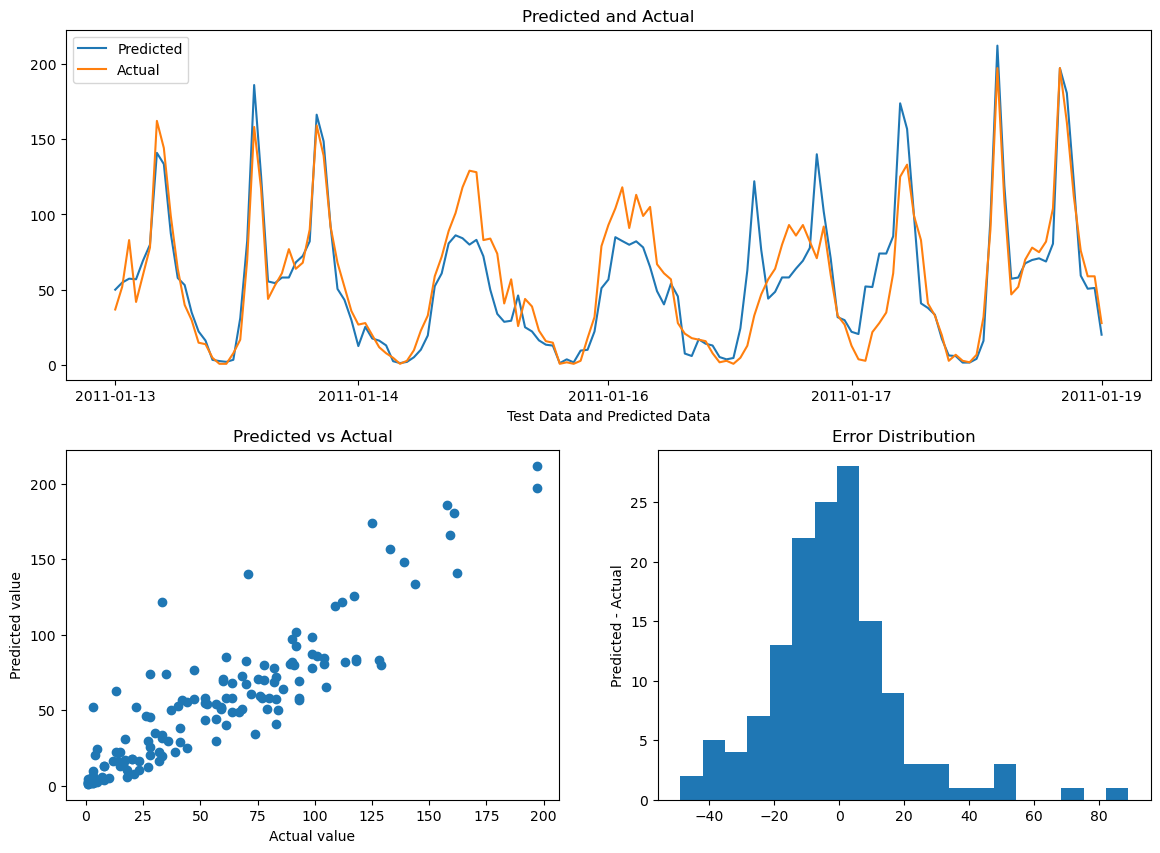

In [13]:
metrics(y_test, y_pred)

The above metrics show that the model can capture the cyclical demand for bicycles to a relatively accurate degree

The model slightly underestimates demand during peak times

There were some large overestimations (around 80 bicycles) but that can be forgiven since it is more acceptable to have more bikes available rather than less

# Production (month 1)

In [14]:
df_current = df.loc['2011-01-29 00:00:00':'2011-02-28 23:00:00']

In [15]:
y_test, y_pred = fit_predict(df_current)

mean error: -8.65500211710368
mean squared error: 1547.5828893273617
root mean squared error: 39.33933005692092
r2 score: 0.7198460895061397


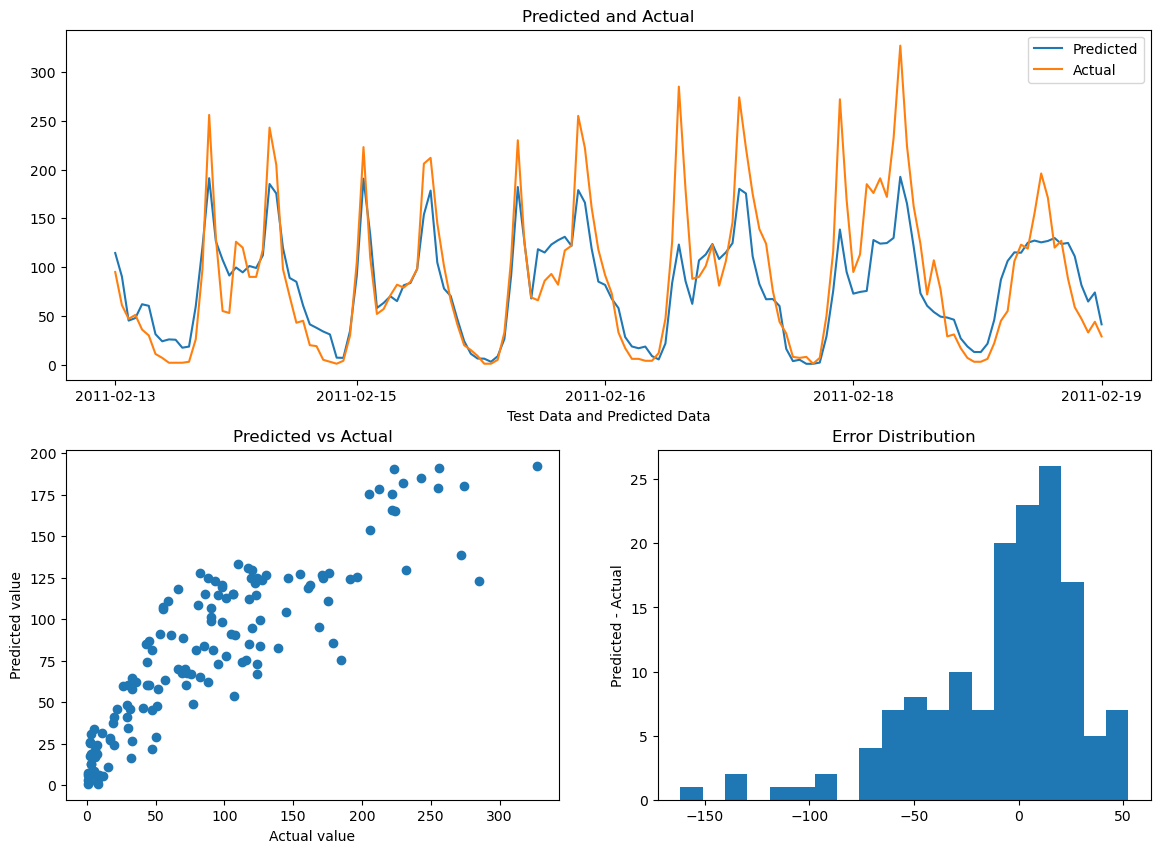

In [16]:
metrics(y_test, y_pred)

During the first month in production, performance degrades across all metrics

More severe underestimation is evident

# Production (month 2)

In [17]:
df_current = df.loc['2011-03-01 00:00:00':'2011-03-31 23:00:00']

In [18]:
y_test, y_pred = fit_predict(df_current)

mean error: -15.595908828582798
mean squared error: 1480.798382009399
root mean squared error: 38.481143200396204
r2 score: 0.8200810001987551


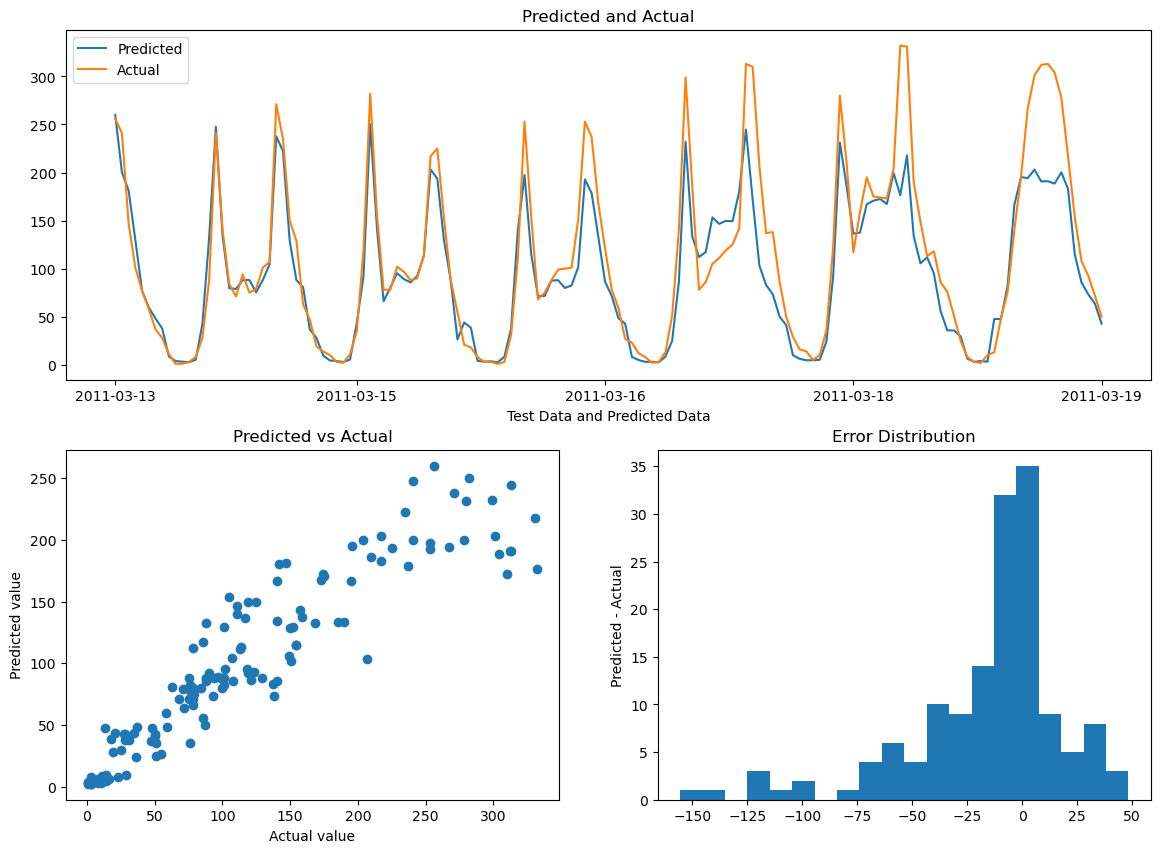

In [19]:
metrics(y_test, y_pred)

# Analysis

Again, performance degrades in production after the second month compared to the reference test data.

The only exception is that the r2 score in month 2 is better than the reference, but all other metrics are significantly worse

The clear trend is that the model is underestimating demand for bicycles as the months pass by.

From our intuition, we can assume that this behavior is due to the nicer weather increasing demand for bicycles.
The model cannot account for that since its training is entirely in January

# Data Drift and Concept Drift

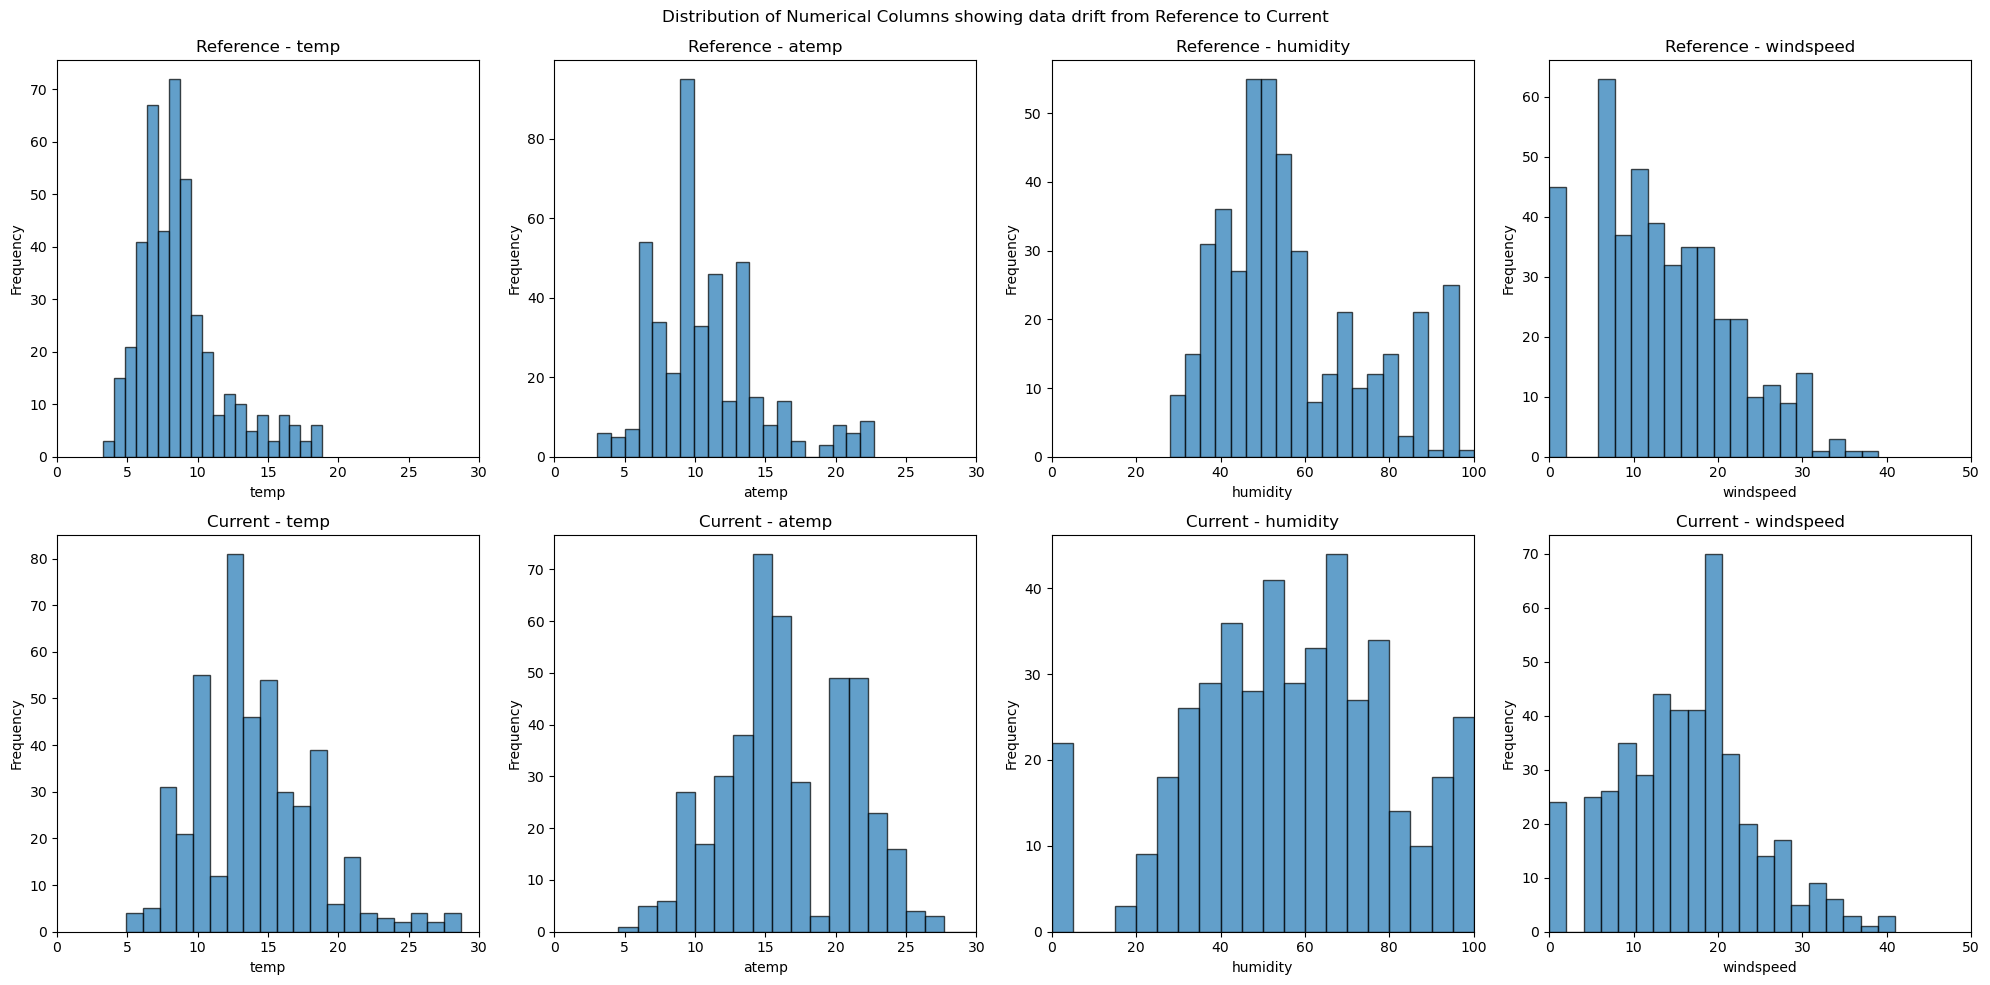

In [20]:
num_cols = ['temp','atemp','humidity','windspeed']
xlims = [(0, 30), (0, 30), (0, 100), (0, 50)]

fig, axs = plt.subplots(2, 4, figsize=(20, 10))
fig.suptitle('Distribution of Numerical Columns showing data drift from Reference to Current')

for idx, df_i in enumerate([df_ref, df_current]):
    for col_idx, col in enumerate(num_cols):
        ax = axs[idx, col_idx]
        ax.hist(df_i[col], bins=20, edgecolor='black', alpha=0.7)
        ax.set_title(f"{'Reference' if idx == 0 else 'Current'} - {col}")
        ax.set_xlabel(col)
        ax.set_ylabel("Frequency")
        ax.set_xlim(xlims[col_idx])
        
plt.tight_layout()
plt.subplots_adjust(top=0.93)

The above plots show significant data drift in the temp and atemp fields and slight data drift in the humidity and windspeed fields

This means that the model would need to be retrained with the new data distribution

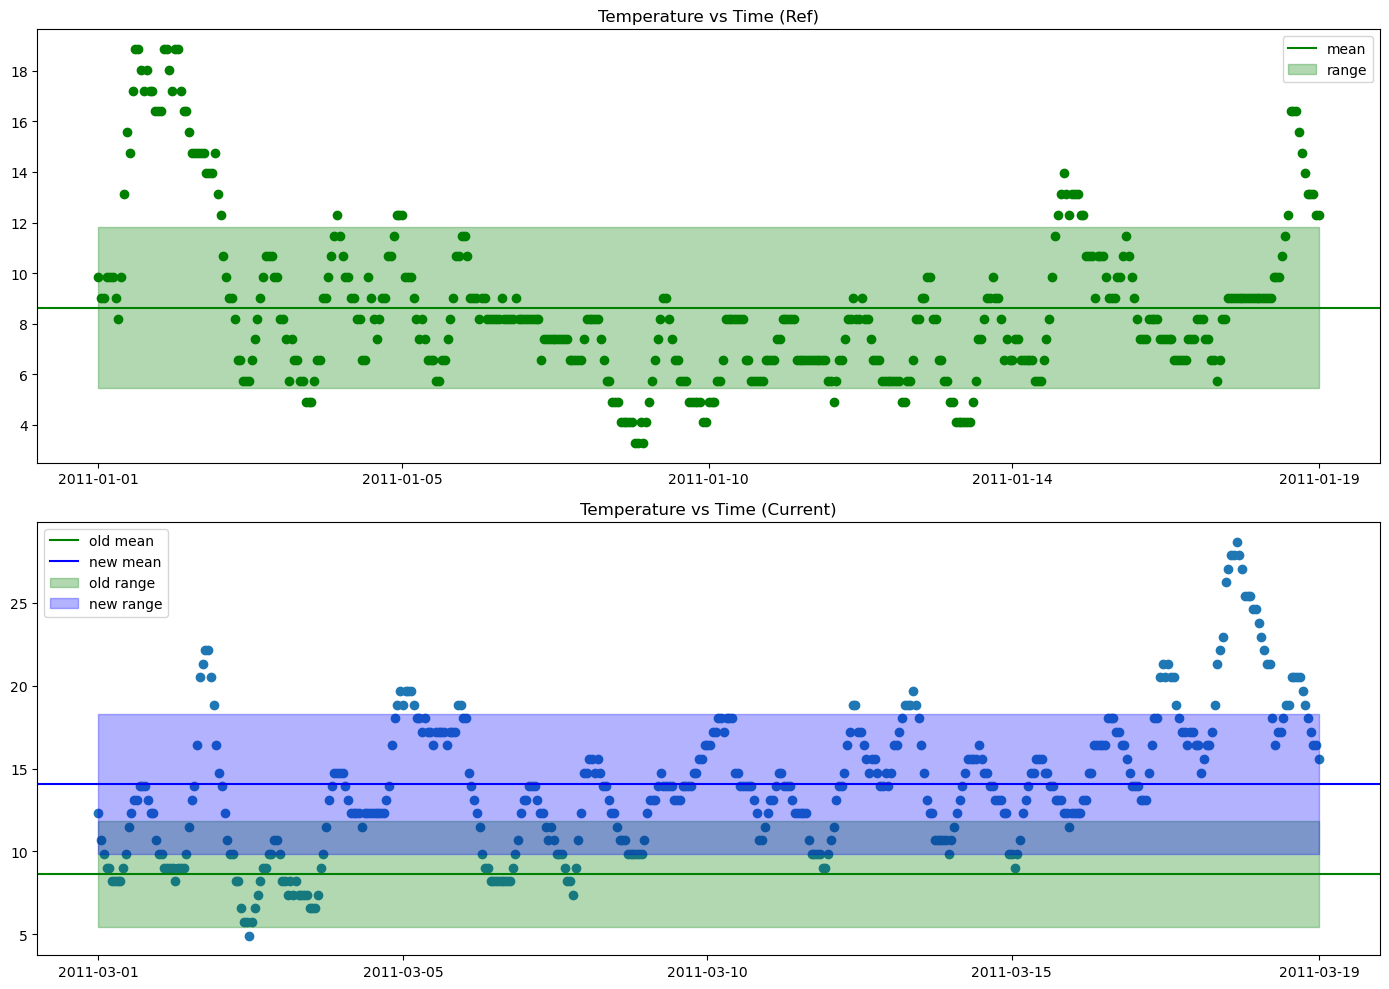

In [32]:
mean_temp_ref = np.mean(df_ref['temp'])
std_dev_temp_ref = np.std(df_ref['temp'])
mean_temp_current = np.mean(df_current['temp'])
std_dev_temp_current = np.std(df_current['temp'])

fig, axs = plt.subplots(2, 1, figsize=(14, 10))

axs[0].scatter(df_ref.index, df_ref['temp'], c='green')
axs[0].axhline(y=mean_temp_ref, color='g', linestyle='-', label='mean')
tick_positions = np.linspace(0, len(df_ref)-1, num=5, dtype=int)
axs[0].set_xticks(ticks=tick_positions)
axs[0].set_xticklabels(pd.to_datetime(df_ref.index)[tick_positions].strftime('%Y-%m-%d'))
axs[0].fill_between(df_ref.index, mean_temp_ref - std_dev_temp_ref, mean_temp_ref + std_dev_temp_ref, color='green', alpha=0.3, label='range')
axs[0].legend()
axs[0].set_title("Temperature vs Time (Ref)")

axs[1].scatter(df_current.index, df_current['temp'])
axs[1].axhline(y=mean_temp_ref, color='g', linestyle='-', label='old mean')
axs[1].axhline(y=mean_temp_current, color='b', linestyle='-', label='new mean')
tick_positions = np.linspace(0, len(df_current)-1, num=5, dtype=int)
axs[1].set_xticks(ticks=tick_positions)
axs[1].set_xticklabels(pd.to_datetime(df_current.index)[tick_positions].strftime('%Y-%m-%d'))
axs[1].fill_between(df_current.index, mean_temp_ref - std_dev_temp_ref, mean_temp_ref + std_dev_temp_ref, color='green', alpha=0.3, label='old range')
axs[1].fill_between(df_current.index, mean_temp_current - std_dev_temp_current, mean_temp_current + std_dev_temp_current, color='blue', alpha=0.3, label='new range')
axs[1].legend()
axs[1].set_title("Temperature vs Time (Current)")

plt.tight_layout()

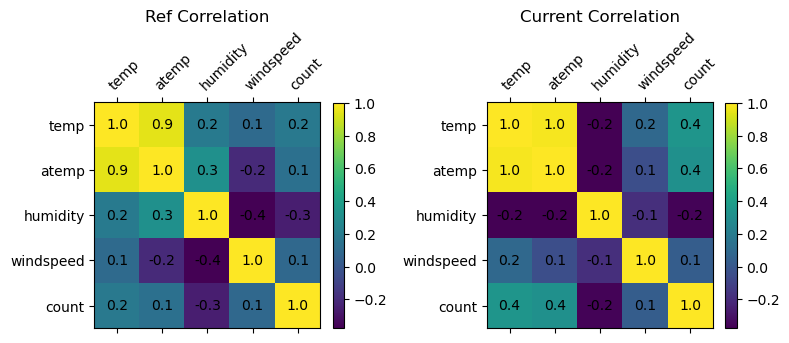

In [52]:
fig, axes = plt.subplots(ncols=2, figsize=(8, 4))
ax1, ax2 = axes

im1 = ax1.matshow(df_ref[num_cols + ['count']].corr())
im2 = ax2.matshow(df_current[num_cols + ['count']].corr())

ax1.set_xticks(range(5))
ax1.set_yticks(range(5))
ax1.set_xticklabels(num_cols + ['count'])
ax1.set_yticklabels(num_cols + ['count'])
ax1.set_title('Ref Correlation')
plt.setp(ax1.get_xticklabels(), rotation=45, ha='left', rotation_mode='anchor')
plt.colorbar(im1, fraction=0.045, pad=0.05, ax=ax1)
for (i, j), z in np.ndenumerate(df_ref[num_cols + ['count']].corr()):
    ax1.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')

ax2.set_xticks(range(5))
ax2.set_yticks(range(5))
ax2.set_xticklabels(num_cols + ['count'])
ax2.set_yticklabels(num_cols + ['count'])
ax2.set_title('Current Correlation')
plt.setp(ax2.get_xticklabels(), rotation=45, ha='left', rotation_mode='anchor')
plt.colorbar(im1, fraction=0.045, pad=0.05, ax=ax2)
for (i, j), z in np.ndenumerate(df_current[num_cols + ['count']].corr()):
    ax2.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')

plt.tight_layout()

Evidence of concept drift can be seen in how the correlation between temp/atemp and count of bicycles changes between ref and current